In [5]:
!pip install dask_ml
!pip install mlflow
!pip install shap
!pip install xgboost
!pip install dask
!pip install xgboost[dask]

In [1]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar(); pbar.register()
import dask.dataframe as dd
import xgboost as xgb
import mlflow
import mlflow.xgboost
import shap
import pandas as pd
import numpy as np
import dask_ml.model_selection as dcv

In [2]:
# Use dask.dataframe to read CSV from S3
import s3fs

fs = s3fs.S3FileSystem(anon=False)
files = fs.ls("medicare-fraud-data-25-05-2025/processed_new/train/")

# Filter non-empty files
valid_files = [f"s3://{file}" for file in files if fs.size(file) > 0]

# Now read only those files
df_train_processed = dd.read_csv(valid_files)


In [25]:
df_train_processed.head(5)

[########################################] | 100% Completed | 101.44 ms
[########################################] | 100% Completed | 102.12 ms


,Provider,Race_mode,PotentialFraud,OperatingPhysician_Most_Frequent,OtherPhysician_Most_Frequent,ClaimDuration_sum,ClaimDuration_mean,ClaimDuration_std,ClaimDuration_max,ClaimDuration_min,...,ClmAdmitDiagnosisCode_Count,ClmDiagnosisCode_1_Count,ClmDiagnosisCode_2_Count,ClmDiagnosisCode_3_Count,Avg_allocated_Amount_Per_Provider,Avg_Deductible_Amt_Paid_Per_Provider,Avg_InscClaimAmtReimbursed_Per_Provider,perc_allocated_used,prv_avg_claim_cost_indicator,prv_avg_claims_indicator
0,PRV52145,0,0,0,0,0.364006,-0.314280,0.181327,0.413384,-0.160337,...,0.313147,0.508396,0.560304,0.509379,-0.477602,-0.375682,-0.423120,0.132287,-0.156164,-0.539095
1,PRV55104,0,0,0,0,-0.246895,-0.305887,0.229961,0.413384,-0.160337,...,-0.218363,-0.188186,-0.173479,-0.177849,0.042061,0.065578,-0.133897,-0.713648,-0.327462,-0.366773
2,PRV54894,0,1,0,0,1.964424,1.194455,1.008662,2.039072,-0.160337,...,2.017108,0.467200,0.716305,1.116283,1.410150,1.397284,1.513495,0.589595,6.155988,-0.431634
3,PRV54927,0,0,0,0,-0.037841,-0.206924,0.322472,0.413384,-0.160337,...,-0.108935,-0.004678,-0.052145,-0.079674,0.108404,-0.226785,0.031728,-0.199320,-0.298733,-0.451401
4,PRV55215,0,1,0,0,12.758541,-0.166513,0.277636,1.930692,-0.160337,...,12.084547,12.088133,12.427935,12.727770,-0.198649,-0.255899,-0.235811,-0.235060,8.119058,-0.075958


In [6]:


# 1) Suppose df_train_processed has columns ["Provider", …, "PotentialFraud"].
#    We’ll split it into two subsets: non-fraud (0) and fraud (1).

df_zero = df_train_processed[df_train_processed.PotentialFraud == 0]
df_one  = df_train_processed[df_train_processed.PotentialFraud == 1]

# 2) For each subset, call `.random_split([0.8, 0.2], random_state=42)` 
#    to get an 80/20 split within that class.

#    Note: random_split returns a list [train_part, test_part].
train_zero, test_zero = df_zero.random_split([0.8, 0.2], random_state=42)
train_one,  test_one  = df_one.random_split([0.8, 0.2], random_state=42)

# 3) Concatenate the “zero” and “one” pieces to form overall train/test sets:
df_train = dd.concat([train_zero, train_one])
df_test  = dd.concat([test_zero,  test_one])

# 4) (Optional) Shuffle each combined DataFrame so the 0/1 examples are interleaved
df_train = df_train.shuffle(on="Provider", random_state=42)
df_test  = df_test.shuffle(on="Provider", random_state=42)

# 5) Finally, separate X_train/y_train and X_test/y_test:
X_train = df_train.drop(columns=["Provider", "PotentialFraud"])
y_train = df_train["PotentialFraud"]

X_test  = df_test.drop(columns=["Provider", "PotentialFraud"])
y_test  = df_test["PotentialFraud"]

# 6) Persist each:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()
y_test  = y_test.persist()


[########################################] | 100% Completed | 609.28 ms
[########################################] | 100% Completed | 408.91 ms
[########################################] | 100% Completed | 411.87 ms
[########################################] | 100% Completed | 309.69 ms


In [ ]:
from dask.distributed import Client

# If you already have a scheduler address, you can pass it here. 
# Otherwise, this will start a local cluster with several threads/processes.
client = Client()


2025-06-08 08:35:57,037 - distributed.scheduler - ERROR - Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments

2025-06-08 08:36:56,328 - distributed.scheduler - ERROR - Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments

2025-06-08 08:38:07,926 - distributed.scheduler - ERROR - Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments

2025-06-08 08:44:41,246 - distributed.scheduler - ERROR - Error during de

In [48]:
import xgboost as xgb

# 3.2.1) Create DaskDMatrix for train and test
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest  = xgb.dask.DaskDMatrix(client, X_test, y_test)


In [10]:
# Count negatives and positives in the training set
neg_count = (y_train == 0).sum().compute()
pos_count = (y_train == 1).sum().compute()




In [15]:
num_boost_round = 100

In [12]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",            # area under ROC
    "tree_method": "hist",           # “hist” is faster on large data
    "scale_pos_weight": scale_pos_weight,
    "learning_rate": 0.1,            # you can tune this later
    "max_depth": 5,                  # also tunable
    "subsample": 0.8,
    "colsample_bytree": 0.8
}
num_boost_round = 100


In [ ]:
output = xgb.dask.train(
    client,
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics


In [ ]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]


In [ ]:
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.5).astype("int64").persist()


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)


In [ ]:
from sklearn.metrics import classification_report

# Collect y_test and y_pred into pandas (only if it fits in memory)
y_test_pd = y_test.compute()
y_pred_pd = y_pred.compute()

print(classification_report(y_test_pd, y_pred_pd, digits=4))


In [35]:
#scale_pos_weight = [9,9.3,9.6,9.9,10.2,10.5,10.8,11.1,11.4,11.7,12.0]

In [34]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install optuna optuna-integration[xgboost]


Note: you may need to restart the kernel to use updated packages.


[10:56:47] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[10:56:47] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1


🔹 AUC: 0.7851
🔹 Best Threshold: 0.40
🔹 F1 Score: 0.3636
🔹 Confusion Matrix:
[[919 105]
 [ 49  44]]


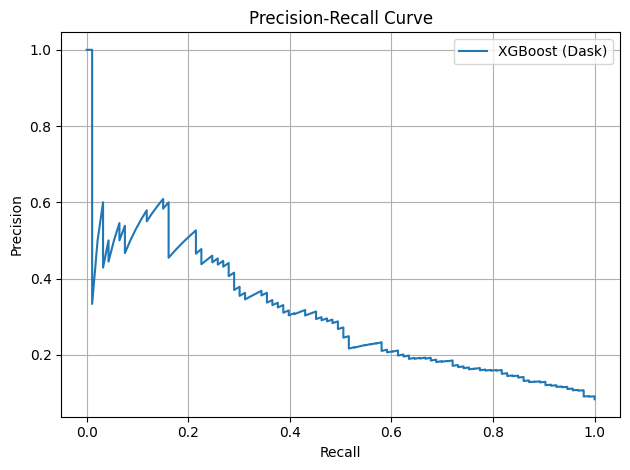

In [78]:
import dask.dataframe as dd
import dask.array as da
import numpy as np
import optuna
from dask.distributed import Client
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import xgboost as xgb

# Connect Dask client
#client = Client()

# Your existing Dask split logic
# Assuming X_train, y_train, X_test, y_test are already defined and persisted
# from your balanced and shuffled Dask pipeline

# --------------------------------------------
# Helper to find best threshold for F1
# --------------------------------------------
def find_best_threshold(y_true, probs):
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = [f1_score(y_true, probs > t) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

# --------------------------------------------
# Evaluation pipeline
# --------------------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1].compute()
    y_true = y_test.compute()

    # ROC AUC
    auc = roc_auc_score(y_true, y_proba)

    # Best F1 threshold
    best_threshold, best_f1 = find_best_threshold(y_true, y_proba)
    y_pred = (y_proba > best_threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    print(f"🔹 AUC: {auc:.4f}")
    print(f"🔹 Best Threshold: {best_threshold:.2f}")
    print(f"🔹 F1 Score: {best_f1:.4f}")
    print(f"🔹 Confusion Matrix:\n{cm}")

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return recall, precision

# --------------------------------------------
# Model: Dask XGBoost
# --------------------------------------------
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": 10,  # Use based on imbalance
    "random_state": 42,
}

model = xgb.dask.DaskXGBClassifier(**params)

# Evaluate
recall, precision = evaluate_model(model, X_train, y_train, X_test, y_test)

# Plot
plt.plot(recall, precision, label="XGBoost (Dask)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
import optuna
from sklearn.metrics import recall_score, f1_score
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client
from optuna.integration import XGBoostPruningCallback

# Optional: Track with Optuna dashboard (optional)
# optuna_dashboard --study-name fraud_optuna --storage sqlite:///optuna_fraud.db

client = Client()  # or connect to existing Dask scheduler

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "tree_method": "hist",
        "eval_metric": "logloss",  # We'll compute F1/Recall manually
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [5, 10, 15, 20]),
    }

    clf = xgb.dask.DaskXGBClassifier(**params)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test).compute()
    y_true = y_test.compute()

    # Choose one based on your goal
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return f1  # or recall

# Use SQLite for persistent tracking
study = optuna.create_study(
    direction="maximize", 
    study_name="fraud_optuna", 
    storage="sqlite:///optuna_fraud.db", 
    load_if_exists=True
)

study.optimize(objective, n_trials=50, timeout=3600)  # Run 50 trials or 1 hour

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_trial.params)


/home/ec2-user/.venv/lib64/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37547 instead
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-559960' coro=<Client._gather.<locals>.wait() done, defined at /home/ec2-user/.venv/lib64/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/ec2-user/.venv/lib64/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit
[I 2025-06-07 10:23:41,364] Using an existing study with name 'fraud_optuna' instead of creating a new one.
2025-06-07 10:23:43,123 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30e4443b416bbd12940b9b8c3d223ffd initialized by task ('shuffle-transfer-30e4443b416bbd12940b9b8c3d223ffd', 2) executed on worker tcp://127.0.0.1:39023
2025-06-07 10:23:

Best trial:
FrozenTrial(number=86, state=TrialState.COMPLETE, values=[0.44559585492227977], datetime_start=datetime.datetime(2025, 6, 7, 10, 26, 14, 970924), datetime_complete=datetime.datetime(2025, 6, 7, 10, 26, 19, 207180), params={'max_depth': 6, 'learning_rate': 0.016597884456664793, 'subsample': 0.5220208038759226, 'colsample_bytree': 0.5234743645466585, 'scale_pos_weight': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'scale_pos_weight': CategoricalDistribution(choices=(5, 10, 15, 20))}, trial_id=87, value=None)
Best params: {'max_depth': 6, 'learning_rate': 0.016597884456664793, 'subsample': 0.5220208038759226, 'colsample_bytree': 0.5234743645466585, 'scale_p

2025-06-07 10:34:05,666 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30e4443b416bbd12940b9b8c3d223ffd initialized by task ('shuffle-transfer-30e4443b416bbd12940b9b8c3d223ffd', 5) executed on worker tcp://127.0.0.1:39763
2025-06-07 10:34:05,845 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30e4443b416bbd12940b9b8c3d223ffd deactivated due to stimulus 'task-finished-1749292445.8416145'
2025-06-07 10:56:47,177 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30e4443b416bbd12940b9b8c3d223ffd initialized by task ('shuffle-transfer-30e4443b416bbd12940b9b8c3d223ffd', 4) executed on worker tcp://127.0.0.1:39763
2025-06-07 10:56:47,438 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 30e4443b416bbd12940b9b8c3d223ffd deactivated due to stimulus 'task-finished-1749293807.4349432'
2025-06-07 11:15:18,165 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b0ffeed5752485965f060655ce4a6d95 initialized by task ('shuffle-transfer-b0ffeed5752485

In [68]:
import numpy as np

import numpy as np

parameters = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': np.float64(9.394673123486683)
}


In [ ]:
best_params = study.best_trial.params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "hist"
})

best_model = xgb.dask.DaskXGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate
y_pred = best_model.predict(X_test).compute()
print("Final F1:", f1_score(y_test.compute(), y_pred))
print("Final Recall:", recall_score(y_test.compute(), y_pred))


[10:34:05] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[10:34:05] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1


Final F1: 0.44559585492227977
Final Recall: 0.46236559139784944


In [69]:
output = xgb.dask.train(
    client,
    parameters,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics

[10:43:22] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1[10:43:22] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0



In [70]:
history

{'validation': OrderedDict([('auc',
               [np.float64(0.7037374371859296),
                np.float64(0.7622592127303183),
                np.float64(0.7558103015075377),
                np.float64(0.7504606365159129),
                np.float64(0.7578203517587939),
                np.float64(0.7592755443886097),
                np.float64(0.7594535175879397),
                np.float64(0.7598408710217756),
                np.float64(0.7638819095477387),
                np.float64(0.7598932160804021),
                np.float64(0.7691164154103852),
                np.float64(0.7694723618090452),
                np.float64(0.7759003350083752),
                np.float64(0.7751675041876047),
                np.float64(0.7748743718592965),
                np.float64(0.7723722780569514),
                np.float64(0.7755757956448911),
                np.float64(0.7728852596314908),
                np.float64(0.7698387772194305),
                np.float64(0.7684149916247907),
    

In [71]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]


In [75]:
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.2).astype("int64").persist()

In [76]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)


Test AUC: 0.7520
Test accuracy: 0.7162
Confusion matrix:
 [[739 285]
 [ 32  61]]


In [77]:
from sklearn.metrics import classification_report

# Collect y_test and y_pred into pandas (only if it fits in memory)
y_test_pd = y_test.compute()
y_pred_pd = y_pred.compute()

print(classification_report(y_test_pd, y_pred_pd, digits=4))


              precision    recall  f1-score   support

           0     0.9585    0.7217    0.8234      1024
           1     0.1763    0.6559    0.2779        93

    accuracy                         0.7162      1117
   macro avg     0.5674    0.6888    0.5507      1117
weighted avg     0.8934    0.7162    0.7780      1117



In [79]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgb_medicaid_fraud"):
    mlflow.log_params(parameters)
    mlflow.log_metric("test_auc", auc_val)
    mlflow.log_metric("test_accuracy", acc_val)
    # Log model (this saves a serialized XGBoost model):
    mlflow.xgboost.log_model(bst, artifact_path="xgb-model")


/home/ec2-user/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:59:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/07 10:59:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


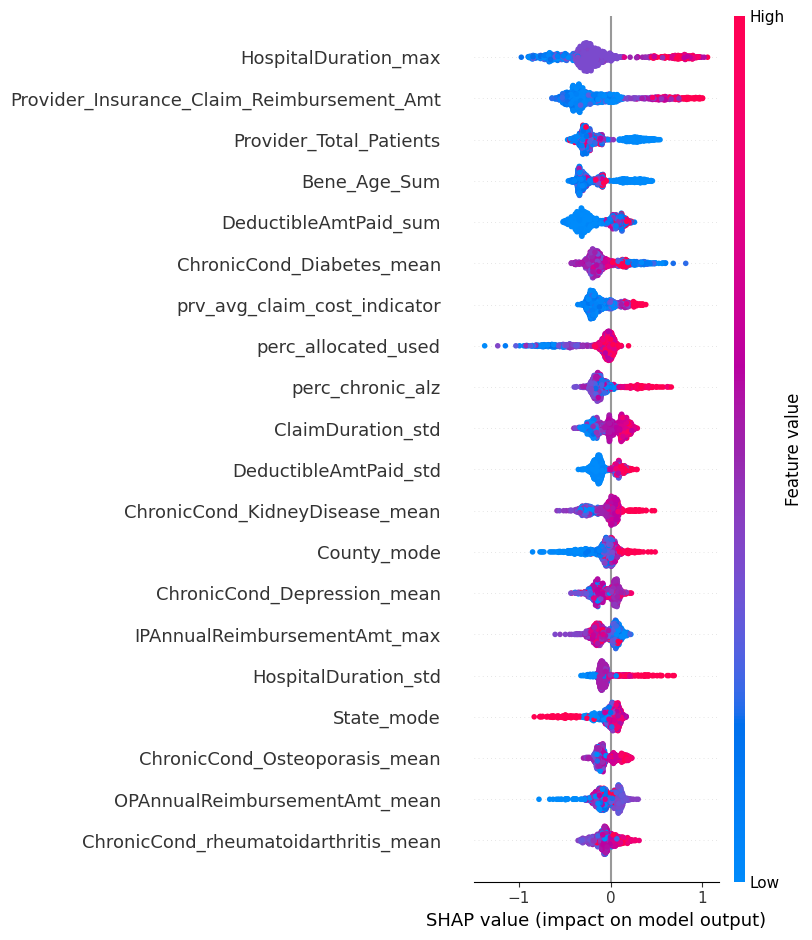

In [80]:
import shap
import xgboost as xgb

# 7.1) Sample a small Pandas subset (max 5,000 rows)
X_test_df = X_test.compute()
X_test_sample = X_test_df.sample(n=min(5000, len(X_test_df)), random_state=42)

# 7.2) Convert to DMatrix
dmatrix_sample = xgb.DMatrix(X_test_sample)

# 7.3) Create a TreeExplainer
explainer = shap.TreeExplainer(bst)

# 7.4) Compute SHAP values
shap_values = explainer.shap_values(dmatrix_sample)

# 7.5) Plot summary
shap.summary_plot(shap_values, X_test_sample)


In [ ]:
df_train_processed_clean= df_train_processed.drop(columns=['State_mode', 'County_mode', 'OPAnnualReimbursementAmt_mean', 'OPAnnualReimbursementAmt_max', 'perc_allocated_used', 'DeductibleAmtPaid_sum'])

In [83]:
import dask.dataframe as dd

# 1) Suppose df_train_processed_clean has columns ["Provider", …, "PotentialFraud"].
#    We’ll split it into two subsets: non-fraud (0) and fraud (1).

df_zero = df_train_processed_clean[df_train_processed_clean.PotentialFraud == 0]
df_one  = df_train_processed_clean[df_train_processed_clean.PotentialFraud == 1]

# 2) For each subset, call `.random_split([0.8, 0.2], random_state=42)` 
#    to get an 80/20 split within that class.

#    Note: random_split returns a list [train_part, test_part].
train_zero, test_zero = df_zero.random_split([0.8, 0.2], random_state=42)
train_one,  test_one  = df_one.random_split([0.8, 0.2], random_state=42)

# 3) Concatenate the “zero” and “one” pieces to form overall train/test sets:
df_train = dd.concat([train_zero, train_one])
df_test  = dd.concat([test_zero,  test_one])

# 4) (Optional) Shuffle each combined DataFrame so the 0/1 examples are interleaved
df_train = df_train.shuffle(on="Provider", random_state=42)
df_test  = df_test.shuffle(on="Provider", random_state=42)

# 5) Finally, separate X_train/y_train and X_test/y_test:
X_train = df_train.drop(columns=["Provider", "PotentialFraud"])
y_train = df_train["PotentialFraud"]

X_test  = df_test.drop(columns=["Provider", "PotentialFraud"])
y_test  = df_test["PotentialFraud"]

# 6) Persist each:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()
y_test  = y_test.persist()


In [84]:
import xgboost as xgb

# 3.2.1) Create DaskDMatrix for train and test
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest  = xgb.dask.DaskDMatrix(client, X_test, y_test)


In [85]:
# Count negatives and positives in the training set
neg_count = (y_train == 0).sum().compute()
pos_count = (y_train == 1).sum().compute()

scale_pos_weight = neg_count / pos_count


In [86]:
import itertools
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import dask.array as da

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8]
}

# Create all combinations
param_combinations = list(itertools.product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["subsample"],
    param_grid["colsample_bytree"]
))

best_auc = -1
best_params = None

for max_depth, learning_rate, subsample, colsample_bytree in param_combinations:
    params = {
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight
    }

    clf = xgb.dask.DaskXGBClassifier(**params)
    clf.fit(X_train, y_train)
    
    y_proba = clf.predict_proba(X_test)[:, 1].compute()
    y_true = y_test.compute()

    auc = roc_auc_score(y_true, y_proba)

    if auc > best_auc:
        best_auc = auc
        best_params = params

print("Best AUC:", best_auc)
print("Best Parameters:", best_params)


[11:17:05] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:05] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:17:07] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:07] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:17:10] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0[11:17:10] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1

[11:17:13] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:13] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:17:16] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:16] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:17:19] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:19] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:17:21] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0[11:17:21] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1

[11:17:24] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:17:24]

Best AUC: 0.9320186491935484
Best Parameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'scale_pos_weight': np.float64(9.394673123486683)}


In [87]:
import numpy as np

parameters = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': np.float64(9.394673123486683)
}


In [88]:
output = xgb.dask.train(
    client,
    parameters,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics

[11:19:59] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1[11:19:59] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0



In [89]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]


In [113]:
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.05).astype("int64").persist()

In [114]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)


Test AUC: 0.9288
Test accuracy: 0.8093
Confusion matrix:
 [[819 205]
 [  8  85]]


In [115]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgb_medicaid_fraud"):
    mlflow.log_params(parameters)
    mlflow.log_metric("test_auc", auc_val)
    mlflow.log_metric("test_accuracy", acc_val)
    # Log model (this saves a serialized XGBoost model):
    mlflow.xgboost.log_model(bst, artifact_path="xgb-model")


/home/ec2-user/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:24:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/07 11:25:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


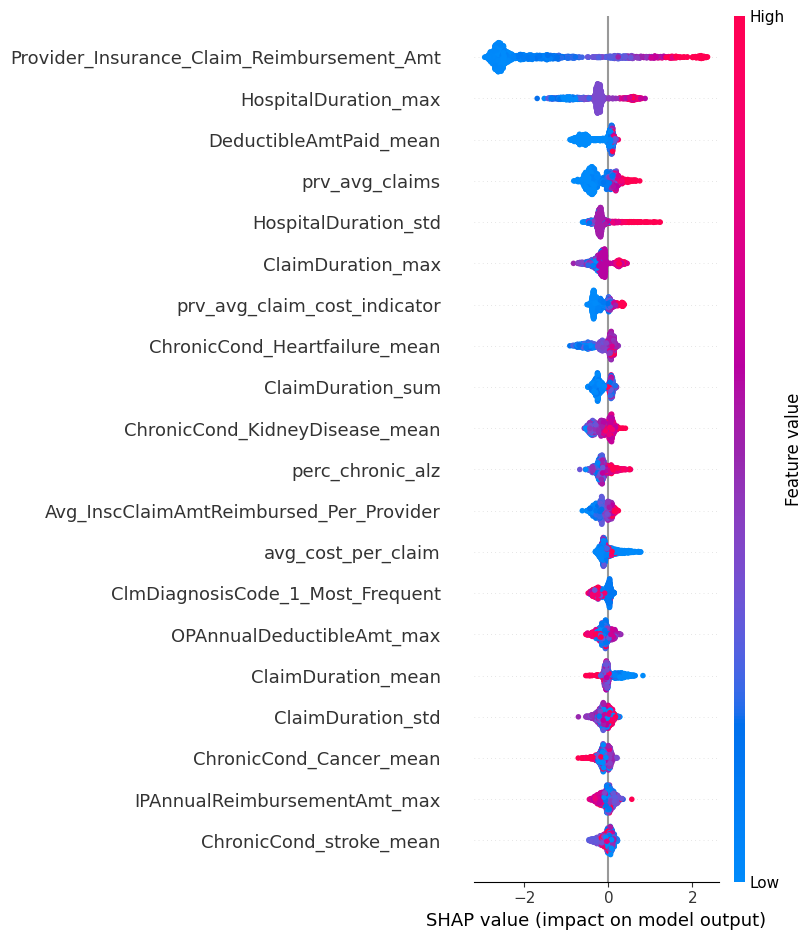

In [116]:
import shap
import xgboost as xgb

# 7.1) Sample a small Pandas subset (max 5,000 rows)
X_test_df = X_test.compute()
X_test_sample = X_test_df.sample(n=min(5000, len(X_test_df)), random_state=42)

# 7.2) Convert to DMatrix
dmatrix_sample = xgb.DMatrix(X_test_sample)

# 7.3) Create a TreeExplainer
explainer = shap.TreeExplainer(bst)

# 7.4) Compute SHAP values
shap_values = explainer.shap_values(dmatrix_sample)

# 7.5) Plot summary
shap.summary_plot(shap_values, X_test_sample)


In [117]:
df_train_processed_cleanN= df_train_processed_clean.drop(columns=['ClmDiagnosisCode_1_Most_Frequent', 'ClaimDuration_mean', 'ChronicCond_Cancer_mean'])

In [118]:
import dask.dataframe as dd

# 1) Suppose df_train_processed_cleanN has columns ["Provider", …, "PotentialFraud"].
#    We’ll split it into two subsets: non-fraud (0) and fraud (1).

df_zero = df_train_processed_cleanN[df_train_processed_cleanN.PotentialFraud == 0]
df_one  = df_train_processed_cleanN[df_train_processed_cleanN.PotentialFraud == 1]

# 2) For each subset, call `.random_split([0.8, 0.2], random_state=42)` 
#    to get an 80/20 split within that class.

#    Note: random_split returns a list [train_part, test_part].
train_zero, test_zero = df_zero.random_split([0.8, 0.2], random_state=42)
train_one,  test_one  = df_one.random_split([0.8, 0.2], random_state=42)

# 3) Concatenate the “zero” and “one” pieces to form overall train/test sets:
df_train = dd.concat([train_zero, train_one])
df_test  = dd.concat([test_zero,  test_one])

# 4) (Optional) Shuffle each combined DataFrame so the 0/1 examples are interleaved
df_train = df_train.shuffle(on="Provider", random_state=42)
df_test  = df_test.shuffle(on="Provider", random_state=42)

# 5) Finally, separate X_train/y_train and X_test/y_test:
X_train = df_train.drop(columns=["Provider", "PotentialFraud"])
y_train = df_train["PotentialFraud"]

X_test  = df_test.drop(columns=["Provider", "PotentialFraud"])
y_test  = df_test["PotentialFraud"]

# 6) Persist each:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()
y_test  = y_test.persist()


In [119]:
import xgboost as xgb

# 3.2.1) Create DaskDMatrix for train and test
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest  = xgb.dask.DaskDMatrix(client, X_test, y_test)


In [122]:
# Count negatives and positives in the training set
neg_count = (y_train == 0).sum().compute()
pos_count = (y_train == 1).sum().compute()

#scale_pos_weight = neg_count / pos_count


In [123]:
import itertools
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import dask.array as da

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "scale_pos_weight": [8.5, 9.394, 11, 13]  # Use the computed scale_pos_weight
}

# Create all combinations
param_combinations = list(itertools.product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["subsample"],
    param_grid["colsample_bytree"],
    param_grid['scale_pos_weight']
))

best_auc = -1
best_params = None

for max_depth, learning_rate, subsample, colsample_bytree, scale_pos_weight in param_combinations:
    params = {
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight
    }

    clf = xgb.dask.DaskXGBClassifier(**params)
    clf.fit(X_train, y_train)
    
    y_proba = clf.predict_proba(X_test)[:, 1].compute()
    y_true = y_test.compute()

    auc = roc_auc_score(y_true, y_proba)

    if auc > best_auc:
        best_auc = auc
        best_params = params

print("Best AUC:", best_auc)
print("Best Parameters:", best_params)


[11:42:34] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0[11:42:34] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1

[11:42:37] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:42:37] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:42:39] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:42:39] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:42:42] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:42:42] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1
[11:42:44] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1[11:42:44] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0

[11:42:47] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0[11:42:47] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1

[11:42:49] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0[11:42:49] Task [xgboost.dask-1]:tcp://127.0.0.1:39763 got rank 1

[11:42:52] Task [xgboost.dask-0]:tcp://127.0.0.1:39023 got rank 0
[11:42:52]

Best AUC: 0.9343392977150538
Best Parameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'scale_pos_weight': 8.5}


In [26]:
import numpy as np

parameters = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': 8.5
}


TRAIN THE MODEL ON THE WHOLE DATA

In [30]:

y_train = df_train_processed["PotentialFraud"]
X_train = df_train_processed.drop(columns=["Provider", "PotentialFraud"])

dtrain_pr = xgb.dask.DaskDMatrix(client, X_train, y_train)

In [33]:
num_boost_round=100
output = xgb.dask.train(
    client,
    parameters,
    dtrain_pr,
    num_boost_round=num_boost_round,
    #evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics

[08:32:53] Task [xgboost.dask-0]:tcp://127.0.0.1:38331 got rank 0
[08:32:53] Task [xgboost.dask-1]:tcp://127.0.0.1:34051 got rank 1


In [148]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.05).astype("int64").persist()

In [150]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)
print("F1 Score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Test AUC: 0.9343
Test accuracy: 0.8147
Confusion matrix:
 [[823 201]
 [  6  87]]
F1 Score: 0.4566929133858268
Confusion Matrix:
 [[823 201]
 [  6  87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      1024
           1       0.30      0.94      0.46        93

    accuracy                           0.81      1117
   macro avg       0.65      0.87      0.67      1117
weighted avg       0.94      0.81      0.85      1117



In [34]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgb_medicaid_fraud"):
    mlflow.log_params(parameters)
    mlflow.log_metric("test_auc", auc_val)
    mlflow.log_metric("test_accuracy", acc_val)
    # Log model (this saves a serialized XGBoost model):
    mlflow.xgboost.log_model(bst, artifact_path="xgb-model")


NameError: name 'auc_val' is not defined

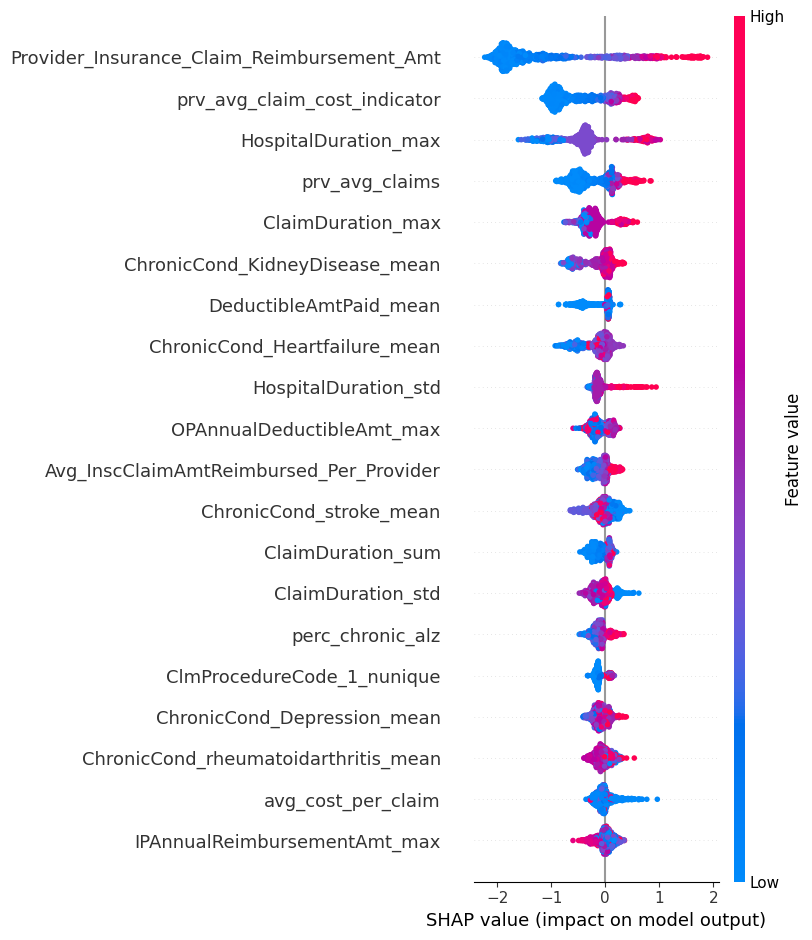

In [139]:
import shap
import xgboost as xgb

# 7.1) Sample a small Pandas subset (max 5,000 rows)
X_test_df = X_test.compute()
X_test_sample = X_test_df.sample(n=min(5000, len(X_test_df)), random_state=42)

# 7.2) Convert to DMatrix
dmatrix_sample = xgb.DMatrix(X_test_sample)

# 7.3) Create a TreeExplainer
explainer = shap.TreeExplainer(bst)

# 7.4) Compute SHAP values
shap_values = explainer.shap_values(dmatrix_sample)

# 7.5) Plot summary
shap.summary_plot(shap_values, X_test_sample)


In [36]:
bst.save_model("xgb_fraud_modelF.json")


In [50]:
import s3fs

fs = s3fs.S3FileSystem()
with fs.open("s3://medicare-fraud-data-25-05-2025/models/xgb_fraud_modelF.json", "wb") as f:
    with open("xgb_fraud_model.json", "rb") as local_file:
        f.write(local_file.read())


In [51]:
import s3fs
import xgboost as xgb
import tempfile

# 1. Initialize s3fs
fs = s3fs.S3FileSystem(anon=False)

# 2. Download the model from S3 and write to a temporary file
with fs.open("s3://medicare-fraud-data-25-05-2025/models/xgb_fraud_modelF.json", "rb") as s3_file:
    with tempfile.NamedTemporaryFile("wb", suffix=".json", delete=False) as temp_file:
        temp_file.write(s3_file.read())
        temp_path = temp_file.name

# 3. Load the model using the local file path
bst_loaded = xgb.Booster()
bst_loaded.load_model(temp_path)



In [52]:
# inference.py
import joblib
import s3fs
import sys
sys.path.append("preprocessor.py")  # or the path to your .py file
from preprocessor import MedicarePreprocessor # 👈 necessary to resolve pickle context

fs = s3fs.S3FileSystem()

with fs.open("s3://medicare-fraud-data-25-05-2025/models/preprocessor.pkl", "rb") as f:
    preprocessor = joblib.load(f)



In [3]:
dic = {
    'Provider': 'category',
    'Race_mode': 'category',
    'State_mode': 'category',
    'County_mode': 'category',
    'PotentialFraud': 'category',
    'Bene_Age_Sum': 'float64',
    'TotalClaims': 'float64',
    'AttendingPhysician_TotalClaims': 'float64',
    'Prv_Physician_Count': 'float64',
    'Provider_Insurance_Claim_Reimbursement_Amt': 'float64',
    'Provider_Total_Patients': 'float64',
    'Provider_Total_ChronicCond_Alzheimer_Patients': 'float64',
    'Provider_Total_ChronicCond_Heartfailure_Patients': 'float64',
    'Provider_Total_ChronicCond_KidneyDisease_Patients': 'float64',
    'Provider_Total_ChronicCond_Cancer_Patients': 'float64',
    'Provider_Total_ChronicCond_ObstrPulmonary_Patients': 'float64',
    'Provider_Total_ChronicCond_Depression_Patients': 'float64',
    'Provider_Total_ChronicCond_Diabetes_Patients': 'float64',
    'Provider_Total_ChronicCond_IschemicHeart_Patients': 'float64',
    'Provider_Total_ChronicCond_Osteoporasis_Patients': 'float64',
    'Provider_Total_ChronicCond_rheumatoidarthritis_Patients': 'float64',
    'Provider_Total_ChronicCond_stroke_Patients': 'float64',
    'ClmAdmitDiagnosisCode_Count': 'float64',
    'ClmDiagnosisCode_1_Count': 'float64',
    'ClmDiagnosisCode_2_Count': 'float64',
    'ClmDiagnosisCode_3_Count': 'float64',
    'ClmAdmitDiagnosisCode_Most_Frequent': 'category',
    'ClmDiagnosisCode_1_Most_Frequent': 'category',
    'ClmDiagnosisCode_2_Most_Frequent': 'category',
    'ClmDiagnosisCode_3_Most_Frequent': 'category',
    'AttendingPhysician_Most_Frequent': 'category',
    'OperatingPhysician_Most_Frequent': 'category',
    'OtherPhysician_Most_Frequent': 'category',
    'Avg_allocated_Amount_Per_Provider': 'float64',
    'Avg_Deductible_Amt_Paid_Per_Provider': 'float64',
    'Avg_InscClaimAmtReimbursed_Per_Provider': 'float64',
    'perc_allocated_used': 'float64',
    'prv_avg_claims': 'float64',
    'prv_avg_claim_cost_indicator': 'float64',
    'prv_avg_claims_indicator': 'float64'
}
merged_path = "s3://medicare-fraud-data-25-05-2025/merged_ready/"
df_test= dd.read_csv(merged_path + 'test/*.csv',dtype=dic, assume_missing=True)



In [4]:
provider_ids = df_test[["Provider"]].compute()  # Convert to pandas for final merge


[########################################] | 100% Completed | 203.04 ms


In [ ]:
from dask.distributed import Client
client = Client()

client.upload_file("preprocessor.py")  # upload class definitions


/home/ec2-user/.venv/lib64/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33067 instead
  warnings.warn(


{'tcp://127.0.0.1:40059': {'status': 'OK'},
 'tcp://127.0.0.1:45805': {'status': 'OK'}}

2025-06-08 14:26:24,257 - distributed.scheduler - ERROR - Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments



In [6]:
from preprocessor import MedicarePreprocessor
preprocessor = MedicarePreprocessor(df_test)
df_test_processed = (
    preprocessor
      .drop_unused_columns()
      .fill_missing()
      .encode_categoricals()   # <- mandatory for XGBoost
      .scale_numeric_features()
      .get_processed_df()
)

/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [16]:
df_test_processed = df_test_processed.drop(columns=["Provider"], errors="ignore")

In [14]:
X_pd = df_test_processed.compute()
dmatrix = xgb.DMatrix(X_pd)

        # Predict
probs = bst_loaded.predict(dmatrix)
preds = (probs > bst_loaded.threshold).astype(int)

[########################################] | 100% Completed | 112.32 ms


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Provider: category

In [64]:
import xgboost as xgb

class MedicareFraudPipeline:
    def __init__(self, preprocessor, booster, threshold=0.05):
        self.preprocessor = preprocessor
        self.booster = booster
        self.threshold = threshold

    def predict(self, dask_df):
        # Preprocess input
        self.preprocessor.df = dask_df
        processed = (
            self.preprocessor
                .drop_unused_columns()
                .fill_missing()
                .encode_categoricals()
                .scale_numeric_features()
                .get_processed_df()
        )

        # Convert to DMatrix (assume label is not present)
        X = processed.drop(columns=["PotentialFraud"], errors="ignore")
        X_pd = X.compute()
        dmatrix = xgb.DMatrix(X_pd, enable_categorical=True)

        # Predict
        probs = self.booster.predict(dmatrix)
        preds = (probs > self.threshold).astype(int)

        return preds, probs


In [65]:
pipeline = MedicareFraudPipeline(preprocessor, bst_loaded, threshold=0.05)


In [62]:
print(type(df_test))


<class 'dask_expr._collection.DataFrame'>


In [66]:
result = pipeline.predict(df_test)
print(type(result))


/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [61]:
df_test_pd = df_test.compute()
preds, probs = pipeline.predict(df_test_pd)

preds, probs = pipeline.predict(df_test)


AttributeError: 'Series' object has no attribute 'compute'

In [31]:
df_train = dd.read_csv(merged_path + 'train/*.csv',dtype=dic, assume_missing=True)


In [32]:
missing_cols = set(df_train.columns) - set(df_test.columns)
extra_cols = set(df_test.columns) - set(df_train.columns)

print("Missing:", missing_cols)
print("Extra:", extra_cols)


Missing: {'PotentialFraud', 'prv_avg_claims'}
Extra: set()


In [14]:
df_test = df_test.persist()

[########################################] | 100% Completed | 658.76 ms


In [35]:
pipeline = MedicareFraudPipeline(preprocessor, bst_loaded, threshold=0.05)
preds, probs = pipeline.predict(df_test)  # df_new = raw Dask DataFrame


KeyError: "['avg_cost_per_claim', 'perc_chronic_alz'] not in index"